In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


# CNN with VGG19 (BaseLine Model)

Import Library

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow.keras.applications.vgg19 import VGG19
from sklearn.metrics import f1_score

Data Directory

In [ ]:
train_dir='/content/drive/MyDrive/Colab Notebooks/Data/Human Emotion Classification/train'
test_dir='/content/drive/MyDrive/Colab Notebooks/Data/Human Emotion Classification/test'

IMG Shape

In [ ]:
img_height, img_width, channel = [224,224,3]

Data Loading & Preprocessing

In [ ]:
preprocess_fun = tf.keras.applications.vgg19.preprocess_input

train_datagen= ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2,
    preprocessing_function=preprocess_fun
)
val_datagen = ImageDataGenerator(rescale=1./255,validation_split = 0.2,preprocessing_function=preprocess_fun)

test_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_fun)

In [ ]:
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='training'
)
val_dataset = val_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='validation'
)

test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

Found 1823 images belonging to 3 classes.
Found 455 images belonging to 3 classes.
Found 569 images belonging to 3 classes.


Baseline Model VGG19

In [ ]:
vgg = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height,img_width,channel)
)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Freezing Layers

In [ ]:
for layer in vgg.layers:
    layer.trainable=False

Creating CNN Model

In [ ]:
models = Sequential()
models.add(vgg)
models.add(Flatten())

#Extra Layer
models.add(Dense(512,activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)))
models.add(BatchNormalization())
models.add(Dense(128, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01)))
models.add(BatchNormalization())
models.add(Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)))
models.add(Dense(3, activation='softmax'))

models.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                        

Plot Model CNN

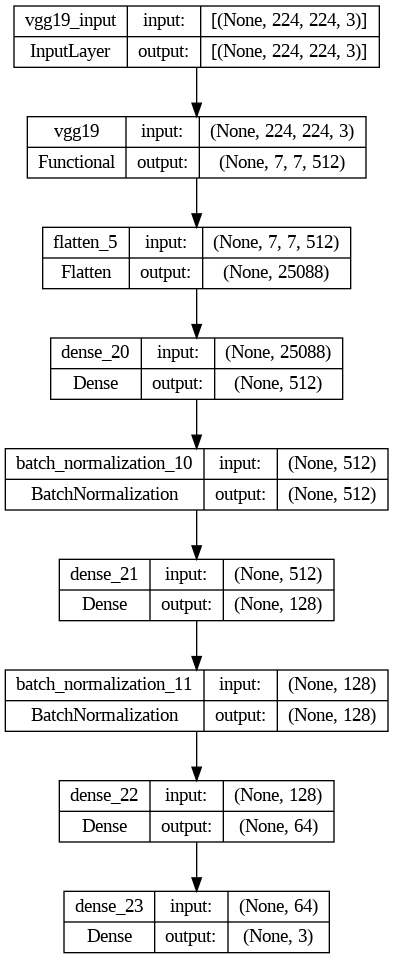

In [ ]:
plot_model(models, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

Callbacks

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15,verbose= 1,restore_best_weights=True)
mcp = tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True,monitor='val_loss')
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 10,verbose = 1,factor = 0.1, min_lr = 1e-10)

Fitting Model

In [ ]:
models.compile(optimizer=tf.optimizers.Adam(learning_rate=0.6),loss='categorical_crossentropy',metrics=['accuracy'])
history= models.fit(
      train_dataset,
      steps_per_epoch=len(train_dataset),
      epochs=30,
      verbose=2,
      validation_data=val_dataset,
      callbacks=[mcp,es,lrd]
      )

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 - 40s - loss: 5217.8711 - accuracy: 0.3489 - val_loss: 1149.7026 - val_accuracy: 0.3846 - lr: 0.6000 - 40s/epoch - 697ms/step
Epoch 2/30
57/57 - 34s - loss: 530.9078 - accuracy: 0.3609 - val_loss: 217.8954 - val_accuracy: 0.2615 - lr: 0.6000 - 34s/epoch - 597ms/step
Epoch 3/30
57/57 - 33s - loss: 330.5213 - accuracy: 0.3390 - val_loss: 508.9557 - val_accuracy: 0.3648 - lr: 0.6000 - 33s/epoch - 587ms/step
Epoch 4/30
57/57 - 34s - loss: 121.3782 - accuracy: 0.3533 - val_loss: 31.1009 - val_accuracy: 0.3736 - lr: 0.6000 - 34s/epoch - 603ms/step
Epoch 5/30
57/57 - 35s - loss: 7.9478 - accuracy: 0.3763 - val_loss: 2.4495 - val_accuracy: 0.3736 - lr: 0.6000 - 35s/epoch - 611ms/step
Epoch 6/30
57/57 - 34s - loss: 1.9431 - accuracy: 0.3692 - val_loss: 1.5980 - val_accuracy: 0.2615 - lr: 0.6000 - 34s/epoch - 594ms/step
Epoch 7/30
57/57 - 34s - loss: 1.4433 - accuracy: 0.3741 - val_loss: 1.3230 - val_accuracy: 0.3648 - lr: 0.6000 - 34s/epoch - 598ms/step
Epoch 8/30
57/57 - 34s - loss: 1.24

Evaluate

In [ ]:
loss, accur = models.evaluate(test_dataset)
preds = models.predict(test_dataset)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_dataset.labels)

18/18 [==============================] - 3s 171ms/step


In [ ]:
f1s = f1_score(y_test,y_preds,average='micro')
print(f'''Loss Data Training: {history.history['loss'][-1]}
Akurasi Data Validasi: {history.history['val_accuracy'][-1]}
Akurasi Data Testing: {accur}
F1Score Data Testing: {f1s}''')

Loss Data Training: 1.0896583795547485
Akurasi Data Validasi: 0.37362638115882874
Akurasi Data Testing: 0.3743409514427185
F1Score Data Testing: 0.37434094903339193
